<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_0926_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이선 머신러닝 완벽 가이드 p. 509 ~ 534

## 텍스트 분류 실습 - 20 뉴스그룹 분류

- 텍스트 분류: 특정 문서의 분류를 학습 데이터를 통해 학습해 모델을 생성한 뒤 이 학습 모델을 이용해 다른 문서의 분류를 예측하는 것
- 희소 행렬에 분류를 효과적으로 잘 처리할 수 있는 알고리즘 : 로지스틱 회귀, 선형 서포트 벡터 머신, 나이브 베이즈 등

<텍스트를 기반으로 분류하는 과정>

텍스트를 정규화한 뒤 피처 벡터화 적용
적합한 머신러닝 알고리즘을 적용해 분류를 학습/예측/평가


In [1]:
# 데이터 내려받기

from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', random_state=156)

In [2]:
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


fetch_20newsgroups() API 역시 load_xxx() API와 유사한 Key 값

In [3]:
# Target 클래스가 어떻게 구성돼 있는지 확인
import pandas as pd

print('target 클래스의 값과 분포도 \n', pd.Series(news_data.target).value_counts().sort_index())
print('target 클래스의 이름들 \n', news_data.target_names)

target 클래스의 값과 분포도 
 0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
Name: count, dtype: int64
target 클래스의 이름들 
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
# 개별 데이터가 텍스트로 어떻게 구성돼 있는지 데이터 한 개의 값 확인

print(news_data.data[0])

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
primary concern is complying with stupid helmet laws, carry a real big
spare (you can put a big or small head in a big helmet, bu

- 내용을 제외하고 제목 등의 다른 정보는 제거
- 순수한 텍스트만으로 구성된 기사 내용으
로 어떤 뉴스그룹에 속하는지 분류할 것


In [5]:
# remove, subset 파라미터 이용

from sklearn.datasets import fetch_20newsgroups

# subset='train' -> 학습데이터 추출
# remove=('headers','footers','quotes') -> 내용만 추출
train_news = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'), random_state=156)
X_train = train_news.data
y_train = train_news.target

# subset='test' -> 테스트데이터 추출
# remove=('headers','footers','quotes') -> 내용만 추출
test_news = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'), random_state=156)
X_test = test_news.data
y_test = test_news.target

print('학습 데이터 크기 {0}, 테스트 데이터 크기 {1}'.format(len(train_news.data), len(test_news.data)))

학습 데이터 크기 11314, 테스트 데이터 크기 7532


### 피처 벡터화 변환과 머신러닝 모델 학습/예측/평가
 - 테스트 데이터에서 CountVectorizer를 적용할 때는 반드시 학습 데이터를 이용해 fit()이 수행된 CountVectorizer 객체를 이용해 테스트 데이터를 변환해야 함
 - 테스트 데이터의 피처 벡터화 시 fit_transform()을 사용하면 안 됨



In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorization으로 피처 벡터화 변환 수행
cnt_vect = CountVectorizer()
cnt_vect.fit(X_train)
X_train_cnt_vect = cnt_vect.transform(X_train)

# 학습 데이터로 fit()된 CountVectorizer를 이용해 테스트 데이터를 피처 벡터화 변환 수행
## 학습 시 설정된 CountVectorizer의 피처 개수와 테스트 데이터를 변환할 피처 개수가 동일하게 하기 위해서
X_test_cnt_vect = cnt_vect.transform(X_test)

print('학습 데이터 텍스트의 CountVectorizer Shape:', X_train_cnt_vect.shape)

학습 데이터 텍스트의 CountVectorizer Shape: (11314, 101631)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# LogisticRegression을 이용해 학습/예측/평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train_cnt_vect, y_train)
pred = lr_clf.predict(X_test_cnt_vect)
print('CountVectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

CountVectorized Logistic Regression의 예측 정확도는 0.604


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화를 적용해 학습 데이터 세트와 테스트 데이터 세트 변환
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

# LogisticRegression을 이용해 학습/예측/평가 수
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Logistic Regression의 예측 정확도는 0.678


<텍스트 분석에서 머신러닝 모델의 성능을 향상시키는 방법>

최적의 ML 알고리즘 선택

최상의 피처 전처리 수행

In [9]:
# stop words 필터링을 추가하고 ngram을 기본 (1,1)에서 (1,2)로 변경해 피처 벡터화 적용
tfidf_vect = TfidfVectorizer(stop_words = 'english', ngram_range = (1,2), max_df = 300)
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))


TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.690


In [10]:
# GridSearchCV 이용
from sklearn.model_selection import GridSearchCV

# 최적 C 값 도출 튜닝 수행. CV는 3 폴드 세트로 설정
params = {'C': [0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr_clf, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv_lr.fit(X_train_tfidf_vect, y_train)
print('Logistic Regression best C parameter:', grid_cv_lr.best_params_)

# 최적 C 값으로 학습된 grid_cv로 예측 및 정확도 평가
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression best C parameter: {'C': 10}
TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.704


### 사이킷런 파이프라인(Pipeline) 사용 및 GridSearchCV와의 결합
- Pipeline 클래스를 이용하면 피처 벡터화와 ML 알고리즘 학습/예측을 위한 코드 작성을 한 번에 진행


In [14]:
from sklearn.pipeline import Pipeline

# Pipeline 객체 선언
pipline = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words = 'english')),
                    ('lr_clf', LogisticRegression(random_state = 156))])

In [16]:
from sklearn.pipeline import Pipeline

# TfidVectorizer 객체를 tfidf_vect로, LogisticRegression 객체를 lr_clf로 생성하는 Pipeline 생성
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words = 'english', ngram_range = (1,2), max_df = 300)),
    ('lr_clf', LogisticRegression(solver = 'liblinear', C = 10))])

# 별도의 TfidVectorizer 객체의 fit(), transform()과 LogisticRegression의 fit(), predict()가 필요 없음
# pipeline의 fit()과 predict()만으로 한꺼번에 피처 벡터화와 ML 학습/예측 가능
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Pipeline을 통한 Logistic Regression의 예측 정확도는 0.704


In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words = 'english')),
                    ('lr_clf', LogisticRegression())])

# Pipeline에 기술된 각각의 객체 변수에 언더바 2개를 연달아 붙여 GridSearchCV에 사용될 파라미터/하이퍼 파라미터 이름과 값을 설정
params = {'tfidf_vect__ngram_range':[(1,1),(1,2),(1,3)],
          'tfidf_vect__max_df':[100, 300, 700],
          'lr_clf__C':[1,5,10]}

# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
grid_cv_pipe = GridSearchCV(pipeline, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv_pipe.fit(X_train, y_train)
print(grid_cv_pipe.best_params_, grid_cv_pipe.best_score_)

pred = grid_cv_pipe.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


## 감성 분석
### 감성 분석 소개
- 문서의 주관적인 감성/의견/감정/기분 등을 파악하기 위한 방법

- 문서 내 텍스트가 나타내는 여러 가지 주관적인 단어와 문맥을 기반으로 감성 수치를 계산하는 방법을 이용함

- 긍정 감정 지수와 부정 감성 지수로 구성되며 이를 합산해 긍정 감성 또는 부정 감성을 결정함

- 지도학습 방식 : 학습 데이터와 타깃 레이블 값을 기반으로 감성 분석 학습을 수행한 뒤 이를 기반으로 다른 데이터의 감성 분석을 예측하는 방법으로 일반적인 텍스트 기반의 분류와 거의 동일함

- 비지도학습 방식 : 'Lexicon'이라는 일종의 감성 어휘 사전 이용, Lexicon은 감성 분석을 위한 용어와 문맥에 대한 다양한 정보를 가지고 있으며, 이를 이용해 문서의 긍정적, 부정적 감성 여부를 판단함

### 지도학습 기반 감성 분석 실습 - IMDB 영화

In [1]:
from google.colab import files

uploaded = files.upload()

Saving labeledTrainData.tsv to labeledTrainData.tsv


In [2]:
import pandas as pd

review_df = pd.read_csv('/content/labeledTrainData.tsv', header = 0, sep = '\t', quoting = 3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


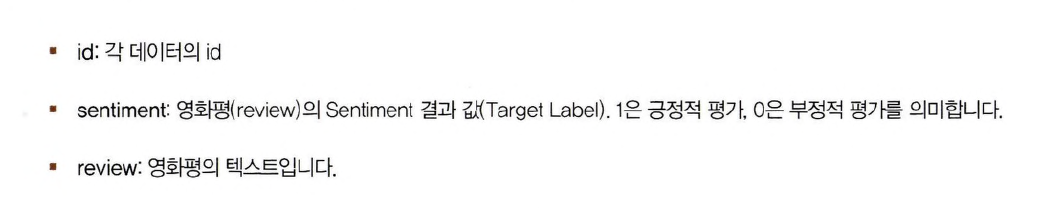

In [3]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [10]:
import re

# Remove HTML tags by replacing them with a space
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# Use regex to keep only English letters and spaces
review_df['review'] = review_df['review'].apply(lambda x : re.sub('[^a-zA-Z ]', ' ', x))

In [7]:
from sklearn.model_selection import train_test_split

# 결정 값 클래스인 sentiment 칼럼을 별도로 추출해 결정 값 데이터 세트 만듦
class_df = review_df['sentiment']
# 원본 데이터 세트에서 id와 sentiment 칼럼을 삭제해 피처 데이터 세트 생성
feature_df = review_df.drop(['id', 'sentiment'], axis=1, inplace=False)

# 학습용과 테스트용 데이터 세트 분리
X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3, random_state=156)
X_train.shape, X_test.shape

((17500, 1), (7500, 1))

In [11]:
# 감상평(Review) 텍스트를 피처 벡터화 -> ML 분류 알고리즘을 적용해 예측 성능을 측정
# Pipeline 객체를 이용해 이 두 가지를 한꺼번에 수행

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, ngram은 (1,2)로 설정해 CountVectorization 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr_clf', LogisticRegression(C=10))])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행
# predict_proba()는 roc_auc 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred), roc_auc_score(y_test, pred_probs)))

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [12]:
# 스톱 워드는 English, filtering, ngram은 (1,2)로 설정해 TF-IDF 벡터화 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words = 'english', ngram_range=(1,2))),
    ('lr_clf', LogisticRegression(solver = 'liblinear', C = 10))
])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행 predict_proba()는 roc_auc 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:4f}, ROC_AUC는 {1:4f}'.format(accuracy_score(y_test, pred), roc_auc_score(y_test, pred_probs)))

ValueError: empty vocabulary; perhaps the documents only contain stop words

### 비지도학습 기반 감성 분석 소개

- 감성 사전은 긍정(Positive) 감성 또는 부정(Negative) 감성의 정도를 의미하는 수치를 가지고 있으며 이를 감성 지수(Polarity score)라고 함
- 시맨틱: 문맥상 의미
- NLP 패키지는 시맨틱을 프로그램
적으로 인터페이스할 수 있는 다양한 방법을 제공
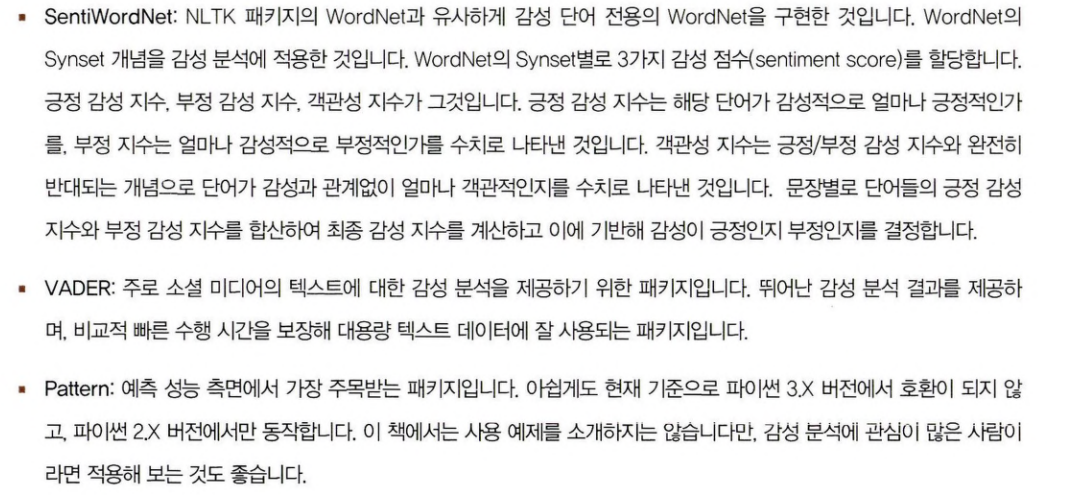


### SentiWordNet을 이용한 감성 분석
#### WordNet SynsetZF SentiWordNet SentiSynset 클래스의 이해

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [ ]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성
synsets = wn.synsets(term)
print('synsets() 반환 type:', type(synsets))
print('synsets() 반환 값 개수:', len(synsets))
print('synsets() 반환 값:', synsets)

In [ ]:
for synset in synsets:
    print('##### Synset name :', synset.name(), '#####')
    print('POS:', synset.lexname())
    print('Definition:', synset.definition())
    print('Lemmas:', synset.lemma_names)

In [ ]:
# synset 객체를 단어별로 생성
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree, lion, tiger, cat, dog]
simliarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset과 유사도를 측정
for entity in entities :
    similarity = [round(entity.path_similarity(compared_entity), 2) for compared_entity in entities]
    simliarities.append(similarity)

# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFramem 형태로 저장
similarity_df = pd.DataFrame(simliarities, columns = entity_names, index = entity_names)
similarity_df

In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type:', type(senti_synsets))
print('senti_synsets() 반환 값 개수:', len(senti_synsets))
print('senti_synsets() 반환 값:', senti_synsets)

In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')

print('father 긍정감성 지수:', father.pos_score())
print('father 부정감성 지수:', father.neg_score())
print('father 객관성 지수:', father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수:', fabulous.pos_score())
print('fabulous 부정감성 지수:', fabulous.neg_score())

#### SentiWordNet을 이용한 영화 감상평 감성 분석
1. 문서(Document)를 문장(Sentence) 단위로 분해
2. 다시 문장을 단어(Word) 단위로 토큰화하고 품사 태깅
3. 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
4. senti_synset 객체에서 긍정 감성/부정 감성 지수를 구하고 이를 모두 합산해 특정 임계치 값 이상일 때 긍정 감성
으로, 그렇지 않을 때는 부정 감성으로 결정



In [ ]:
from nltk.corpus import wordnet as wn

# 간단한 NLTK PennTreebank Tag을 기반으로 WordNet 기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화
    sentiment = 0.0
    tokens_count = 0

    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word, tag in tagged_sentence:

            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos = wn_tag)
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체 생성
            synsets = wn.synsets(lemma, pos = wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
            tokens_count += 1

        if not tokens_count:
            return 0

        # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
        if sentiment >= 0 :
            return 1

        return 0

In [ ]:
review_df['preds'] = review_df['review'].apply(lambda x: swn_polarity(x))
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print("정확도 : ", np.round(accuracy_score(y_target, preds), 4))
print("정밀도: ", np.round(precision_score(y_target, preds), 4))
print("재현율: ", np.round(recall_score(y_target, preds), 4))

### VADER를이용한 감성분석

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

In [ ]:
def vader_polarity(review, threshold=0.1):
  analyzer = SentimentIntensityAnalyzer()
  scores = analyzer.polarity_scores(review)

  # compound 값에 기반해 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
  agg_score = scores['compound']
  final_sentiment = 1 if agg_score >= threshold else 0
  return final_sentiment

# apply lambda 식을 이용해 레코드별로 vader_polarity()를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply(lambda x: vader_polarity(x, 0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix(y_target, vader_preds))
print("정확도:", np.round(accuracy_score(y_target, vader_preds), 4))
print("정밀도:", np.round(precision_score(y_target, vader_preds), 4))
print("재현율:", np.round(recall_score(y_target, vader_preds), 4))